In [1]:
from __future__ import print_function
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as dset
from torchvision import transforms

c:\Users\twelve\.conda\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # 定义编码器
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
        )
        self.encoder_fc1=nn.Linear(32*7*7,nz)
        self.encoder_fc2=nn.Linear(32*7*7,nz)
        self.Sigmoid = nn.Sigmoid()
        self.decoder_fc = nn.Linear(nz+10,32 * 7 * 7)
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
            nn.Sigmoid(),
        )

    def noise_reparameterize(self,mean,logvar):
        eps = torch.randn(mean.shape).to(device)
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, x):
        z = self.encoder(x)
        output = self.decoder(z)
        return output
    def encoder(self,x):
        out1, out2 = self.encoder_conv(x), self.encoder_conv(x)
        mean = self.encoder_fc1(out1.view(out1.shape[0], -1))
        logstd = self.encoder_fc2(out2.view(out2.shape[0], -1))
        z = self.noise_reparameterize(mean, logstd)
        return z,mean,logstd
    def decoder(self,z):
        out3 = self.decoder_fc(z)
        out3 = out3.view(out3.shape[0], 32, 7, 7)
        out3 = self.decoder_deconv(out3)
        return out3

Random Seed: 88
=====> 构建VAE


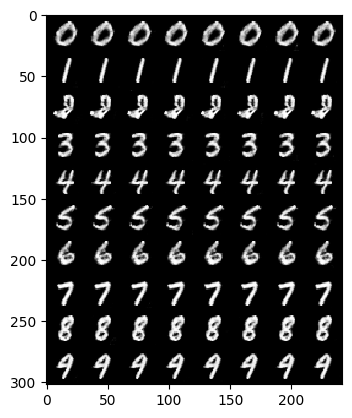

In [3]:
dataset = 'mnist'
batchSize = 128
imageSize = 28
nz=100
device='cpu'
print("Random Seed: 88")
random.seed(88)
torch.manual_seed(88)
# 可以优化运行效率
cudnn.benchmark = True
print("=====> 构建VAE")
vae = VAE()
vae.load_state_dict(torch.load('./CVAE-GAN-VAE.pth'))
outputs = []
for num in range(10):
    label = torch.Tensor([num]).repeat(8).long()
    label_onehot = torch.zeros((8, 10))
    label_onehot[torch.arange(8), label] = 1
    z = torch.randn((8, nz))
    z = torch.cat([z, label_onehot], 1)
    outputs.append(vae.decoder(z).view(z.shape[0], 1, 28, 28))
outputs = torch.cat(outputs)
img = make_grid(outputs, nrow=8, normalize=False).clamp(0, 1).detach().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')
plt.show()

In [4]:
 # 产生渐变
dataset = dset.MNIST(root='./data',
                        train=True,
                        transform=transforms.Compose([transforms.ToTensor()]),
                        download=True
                        )
n_channel = 1
dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batchSize,
                                            shuffle=True)



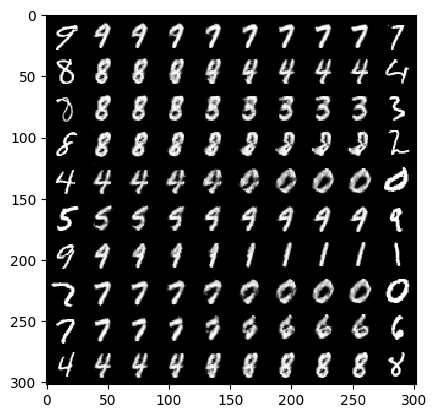

In [5]:
list = []
for n in range(10):
    for i, (data, lab) in enumerate(dataloader, 0):
        number1 = data[0].view(1, 1, 28, 28)
        number2 = data[1].view(1, 1, 28, 28)
        label_onehot = torch.zeros((data.shape[0], 10))
        label_onehot[torch.arange(data.shape[0]), lab] = 1
        label1 = lab[0]
        label1_onehot = label_onehot[0].view(1, 10)
        label2 = lab[1]
        label2_onehot = label_onehot[1].view(1, 10)
        z1, mean1, logstd1 = vae.encoder(number1)
        z2, mean1, logstd1 = vae.encoder(number2)
        z1 = torch.cat([z1, label1_onehot], 1)
        z2 = torch.cat([z2, label2_onehot], 1)
        step = (z2 - z1) / 8
        list.append(number1)
        for n in range(8):
            z = z1 + (n + 1) * step
            output = vae.decoder(z)
            list.append(output)
        list.append(number2)
        break
photos = torch.cat(list)
img = make_grid(photos, nrow=10, normalize=True).detach().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')
plt.show()

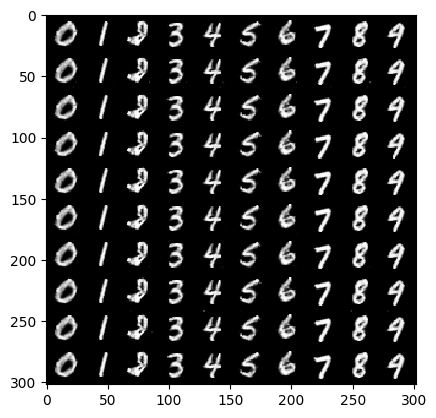

In [6]:
list = []
for n in range(10):
    for i, (data,lab) in enumerate(dataloader, 0):
        number1 = data[0].view(1,1,28,28)
        number2 = data[1].view(1,1,28,28)
        label = torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long()
        label_onehot = torch.zeros((label.shape[0], 10))
        label_onehot[torch.arange(label.shape[0]), label] = 1
        z1,mean1,logstd1 = vae.encoder(number1)
        z1 = z1.repeat(10,1)
        z1 = torch.cat([z1,label_onehot],1)
        output = vae.decoder(z1)
        list.append(output)
        break
photos = torch.cat(list)
img = make_grid(photos, nrow=10, normalize=True).detach().numpy()
plt.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')
plt.show()